In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-default-dataset/Loan_Default.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import category_encoders as ce
import pandas as pd
import numpy as np
from scipy.stats import skew
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, classification_report, 
                           confusion_matrix, roc_curve, precision_recall_curve)

In [4]:
df = pd.read_csv("/kaggle/input/loan-default-dataset/Loan_Default.csv")

In [5]:
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [6]:

print(df.shape)
print(df.info())
print(df['Status'].value_counts(normalize=True))  # Class balance check

(148670, 34)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges 

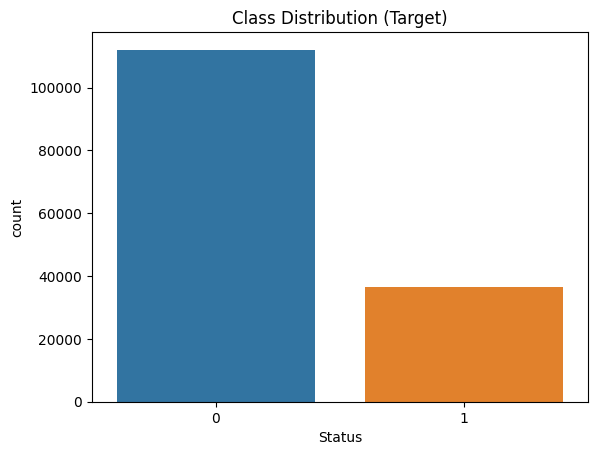

In [7]:
sns.countplot(x='Status', data=df)
plt.title("Class Distribution (Target)")
plt.show()

<Axes: >

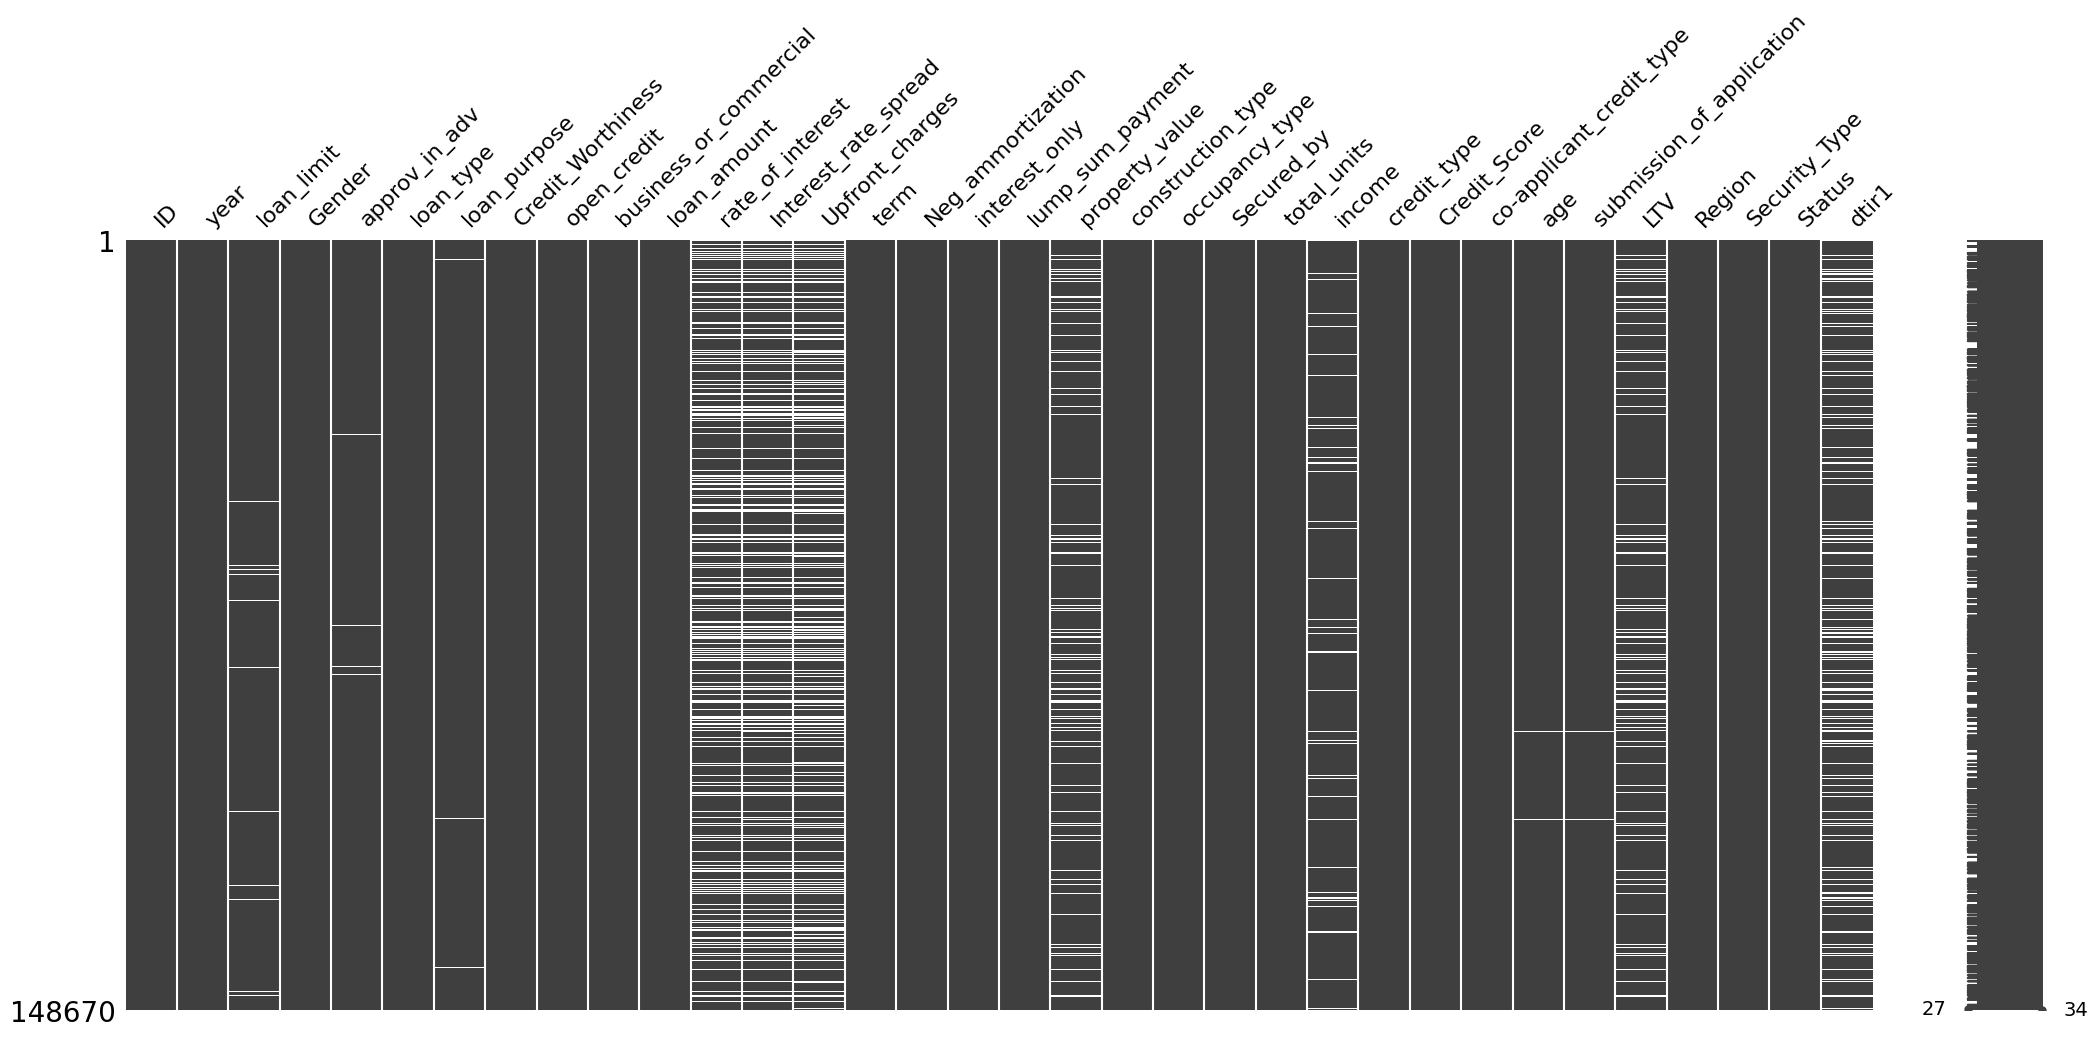

In [8]:
import missingno as msno

# Matrix plot 
msno.matrix(df)

In [9]:
# duplicate rows & duplicate IDs
dup_rows = int(df.duplicated().sum())
dup_ids = {}
ID_COLS = ["ID"] 
for c in ID_COLS:
    if c in df.columns:
        dup_ids[c] = int(df[c].duplicated().sum())

print("\n=== DUPLICATE ROWS ===", dup_rows)
print("\n=== DUPLICATE IDs ===", dup_ids)


=== DUPLICATE ROWS === 0

=== DUPLICATE IDs === {'ID': 0}


In [10]:
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [11]:
# cardinality (unique counts) per column
card = df.nunique(dropna=False).sort_values(ascending=False)
print(card)

ID                           148670
Upfront_charges               58272
Interest_rate_spread          22517
LTV                            8485
income                         1002
Credit_Score                    401
property_value                  386
loan_amount                     211
rate_of_interest                132
dtir1                            58
term                             27
age                               8
loan_purpose                      5
total_units                       4
Region                            4
credit_type                       4
Gender                            4
Neg_ammortization                 3
loan_type                         3
loan_limit                        3
occupancy_type                    3
submission_of_application         3
approv_in_adv                     3
co-applicant_credit_type          2
Status                            2
Security_Type                     2
business_or_commercial            2
open_credit                 

In [12]:
      
# missingness per column
na = (
    df.isna().sum()
      .to_frame("n_missing")
      .assign(pct=lambda x: (100 * x["n_missing"] / len(df)).round(2)) # gives percentage of missing values
      .sort_values("pct", ascending=False)
)
# show top 10 worst columns
na.head(10)

,n_missing,pct
Upfront_charges,39642,26.66
Interest_rate_spread,36639,24.64
rate_of_interest,36439,24.51
dtir1,24121,16.22
LTV,15098,10.16
property_value,15098,10.16
income,9150,6.15
loan_limit,3344,2.25
approv_in_adv,908,0.61
submission_of_application,200,0.13


In [13]:
df[['rate_of_interest', 'Interest_rate_spread']].dropna().corr()

,rate_of_interest,Interest_rate_spread
rate_of_interest,1.000000,0.614908
Interest_rate_spread,0.614908,1.000000


0.614908 - moderate to strong correlation

In [14]:
df['rate_missing'] = df['rate_of_interest'].isna().astype(int)

print(df.groupby('rate_missing')['Status'].value_counts(normalize=True))  #can be a leakage column

rate_missing  Status
0             0         0.998218
              1         0.001782
1             1         1.000000
Name: proportion, dtype: float64


99.8% of missing rate_of_interest values correspond to the status 0 - i.e the loan was not defaulted

In [15]:
# we can drop on of them - let's keep rat_of_interest because it is an interpretable, easier-to-explain feature 
df = df.drop(columns = ["Interest_rate_spread"])

In [16]:
df.shape

(148670, 34)

In [17]:
# constant columns (zero variance)
constant_cols = card[card <= 1].index.tolist()
print("\n=== CONSTANT COLUMNS ===", constant_cols)


=== CONSTANT COLUMNS === ['year']


In [18]:
#dropping the constant column, will keep year 2019 as documentation
df = df.drop(columns=constant_cols)

In [19]:
#detect quasi constant columns
threshold = 0.99
quasi_constant_cols = [
    col for col in df.columns
    if (df[col].value_counts(normalize=True).values[0] > threshold)
]

quasi_constant_cols

['open_credit', 'construction_type', 'Secured_by', 'Security_Type']

In [20]:
for col in quasi_constant_cols:
    print(f"\nColumn: {col}")
    print(df[col].value_counts(normalize=True).round(3))


Column: open_credit
open_credit
nopc    0.996
opc     0.004
Name: proportion, dtype: float64

Column: construction_type
construction_type
sb    1.0
mh    0.0
Name: proportion, dtype: float64

Column: Secured_by
Secured_by
home    1.0
land    0.0
Name: proportion, dtype: float64

Column: Security_Type
Security_Type
direct      1.0
Indriect    0.0
Name: proportion, dtype: float64


In [21]:
for col in quasi_constant_cols:
    print(f"\nColumn: {col}")
    print(df.groupby(col)["Status"].value_counts(normalize=True).unstack())


Column: open_credit
Status              0         1
open_credit                    
nopc         0.753291  0.246709
opc          0.823741  0.176259

Column: construction_type
Status                    0         1
construction_type                    
mh                      NaN  1.000000
sb                 0.753722  0.246278

Column: Secured_by
Status             0         1
Secured_by                    
home        0.753722  0.246278
land             NaN  1.000000

Column: Security_Type
Status                0         1
Security_Type                    
Indriect            NaN  1.000000
direct         0.753722  0.246278


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

here construction_type, secured_by and security type can be dropped, but open_credit does have some explaining power so we keep it

In [22]:
#Drop the quasi-constant / noisy columns
df = df.drop(columns=['construction_type', 'Secured_by', 'Security_Type'])

In [23]:
df.shape

(148670, 30)

In [24]:
# ID is basically like an identifier - so let's just set it as an index
df = df.set_index("ID")

In [25]:
df.columns

Index(['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose',
       'Credit_Worthiness', 'open_credit', 'business_or_commercial',
       'loan_amount', 'rate_of_interest', 'Upfront_charges', 'term',
       'Neg_ammortization', 'interest_only', 'lump_sum_payment',
       'property_value', 'occupancy_type', 'total_units', 'income',
       'credit_type', 'Credit_Score', 'co-applicant_credit_type', 'age',
       'submission_of_application', 'LTV', 'Region', 'Status', 'dtir1',
       'rate_missing'],
      dtype='object')

In [26]:
# select categorical columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns

# loop through categorical columns
for col in cat_cols:
    print(f"\nColumn: {col}")
    print(df[col].value_counts(dropna=False, normalize=True).round(3))


Column: loan_limit
loan_limit
cf     0.910
ncf    0.067
NaN    0.022
Name: proportion, dtype: float64

Column: Gender
Gender
Male                 0.285
Joint                0.278
Sex Not Available    0.253
Female               0.183
Name: proportion, dtype: float64

Column: approv_in_adv
approv_in_adv
nopre    0.838
pre      0.156
NaN      0.006
Name: proportion, dtype: float64

Column: loan_type
loan_type
type1    0.761
type2    0.140
type3    0.099
Name: proportion, dtype: float64

Column: loan_purpose
loan_purpose
p3     0.376
p4     0.369
p1     0.232
p2     0.022
NaN    0.001
Name: proportion, dtype: float64

Column: Credit_Worthiness
Credit_Worthiness
l1    0.957
l2    0.043
Name: proportion, dtype: float64

Column: open_credit
open_credit
nopc    0.996
opc     0.004
Name: proportion, dtype: float64

Column: business_or_commercial
business_or_commercial
nob/c    0.86
b/c      0.14
Name: proportion, dtype: float64

Column: Neg_ammortization
Neg_ammortization
not_neg    0.897
neg_

In [27]:

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
import category_encoders as ce

def create_categorical_pipeline(df, target_col, cardinality_threshold=10):
    """
    Prepares a preprocessing pipeline for categorical variables with dynamic encoding.

    Parameters:
    -----------
    df : pd.DataFrame
        Input dataframe containing categorical variables.
    target_col : str
        Name of the target column (needed for target encoding).
    cardinality_threshold : int
        Max unique categories to allow one-hot encoding. 
        Above this → target encoding.

    Returns:
    --------
    preprocessor : ColumnTransformer
        Transformer ready to fit_transform on categorical features.
    encoding_summary : dict
        Mapping of column → encoding type and categories (for interpretability).
    """

    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    cat_cols = [col for col in cat_cols if col != target_col]

    encoding_summary = {}
    transformers = []

    for col in cat_cols:
        unique_vals = df[col].nunique(dropna=True)

        if unique_vals <= cardinality_threshold:
            # One-hot encoding for low cardinality
            transformers.append(
                (f"{col}_onehot",
                 Pipeline(steps=[
                     ("imputer", SimpleImputer(strategy="most_frequent")),
                     ("encoder", OneHotEncoder(handle_unknown="ignore"))
                 ]),
                 [col])
            )
            encoding_summary[col] = {
                "encoding": "one-hot",
                "categories": df[col].unique().tolist()
            }

        else:
            # Target encoding for high cardinality
            transformers.append(
                (f"{col}_target",
                 Pipeline(steps=[
                     ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
                     ("encoder", ce.TargetEncoder(cols=[col]))
                 ]),
                 [col])
            )
            encoding_summary[col] = {
                "encoding": "target",
                "categories": df[col].unique().tolist()
            }

    # Combine into a single ColumnTransformer
    preprocessor = ColumnTransformer(transformers, remainder="drop")

    return preprocessor, encoding_summary

In [28]:
create_categorical_pipeline(df, target_col= "Status", cardinality_threshold=10)

(ColumnTransformer(transformers=[('loan_limit_onehot',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('encoder',
                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                  ['loan_limit']),
                                 ('Gender_onehot',
                                  Pipeline(steps=[('imputer',
                                                   SimpleImputer(strategy='most_frequent')),
                                                  ('encoder',
                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                  ['Gender']),
                                 ('approv_i...
                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                 

In [29]:
# status - target variable is of type numeric so we separate it before proceeding with any transformation

# Separate target
X = df.drop("Status", axis=1) 
y = df["Status"]

In [30]:


import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import skew

num_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Basic Summary

def numerical_summary(df, num_cols):
    summary = pd.DataFrame({
        'missing_%': df[num_cols].isnull().mean() * 100,
        'mean': df[num_cols].mean(),
        'median': df[num_cols].median(),
        'std': df[num_cols].std(),
        'min': df[num_cols].min(),
        'max': df[num_cols].max(),
        'skewness': df[num_cols].skew()
    })
    return summary

numerical_summary(X,num_cols)

,missing_%,mean,median,std,min,max,skewness
loan_amount,0.000000,331117.743997,296500.00000,183909.310127,16500.000000,3576500.00,1.666998
rate_of_interest,24.509989,4.045476,3.99000,0.561391,0.000000,8.00,0.388406
Upfront_charges,26.664425,3224.996127,2596.45000,3251.121510,0.000000,60000.00,1.754076
term,0.027578,335.136582,360.00000,58.409084,96.000000,360.00,-2.174822
property_value,10.155378,497893.465696,418000.00000,359935.315562,8000.000000,16508000.00,4.586276
income,6.154571,6957.338876,5760.00000,6496.586382,0.000000,578580.00,17.307695
Credit_Score,0.000000,699.789103,699.00000,115.875857,500.000000,900.00,0.004767
LTV,10.155378,72.746457,75.13587,39.967603,0.967478,7831.25,120.615337
dtir1,16.224524,37.732932,39.00000,10.545435,5.000000,61.00,-0.551465
rate_missing,0.000000,0.245100,0.00000,0.430148,0.000000,1.00,1.185190


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


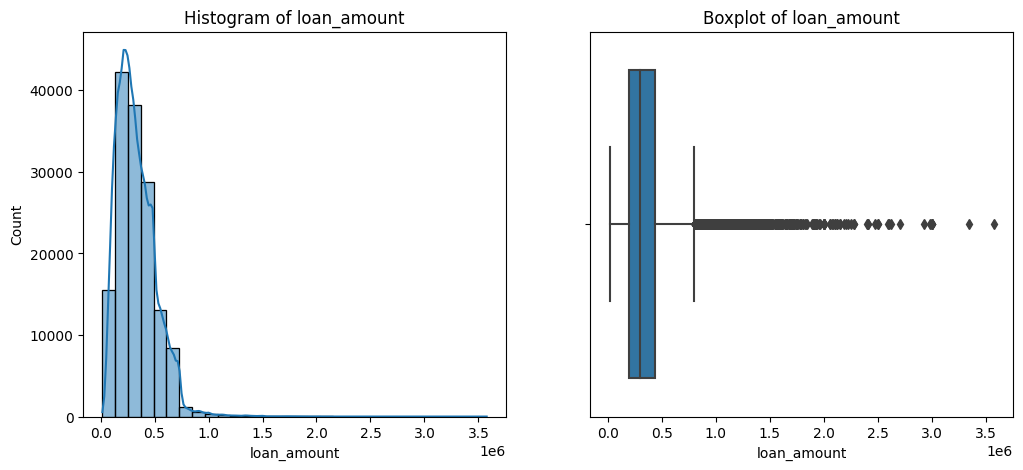

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


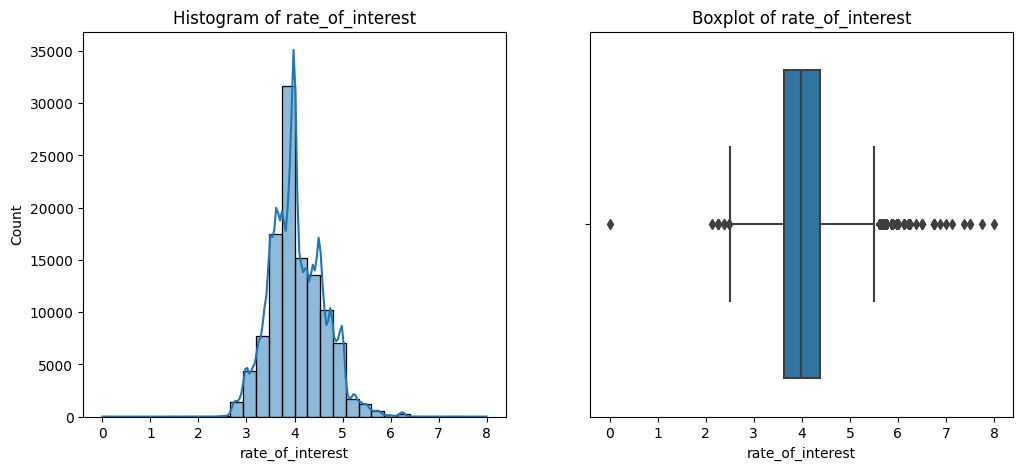

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


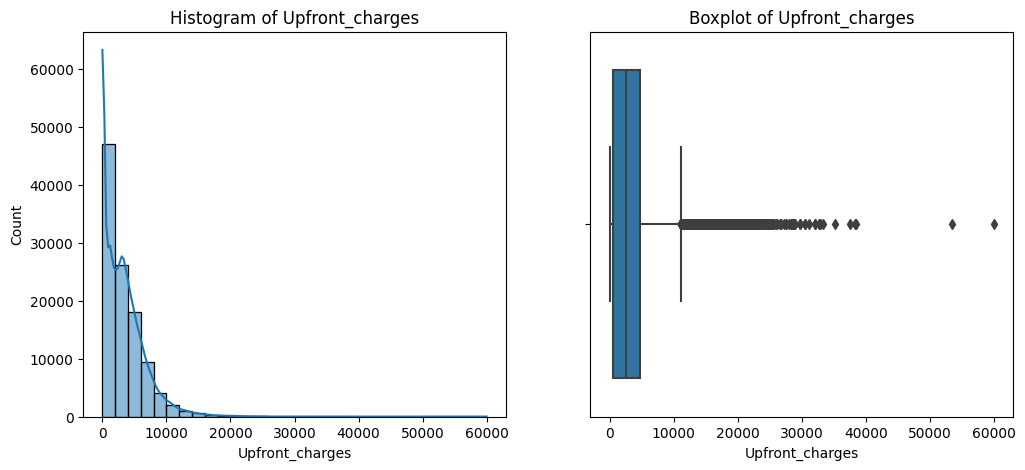

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


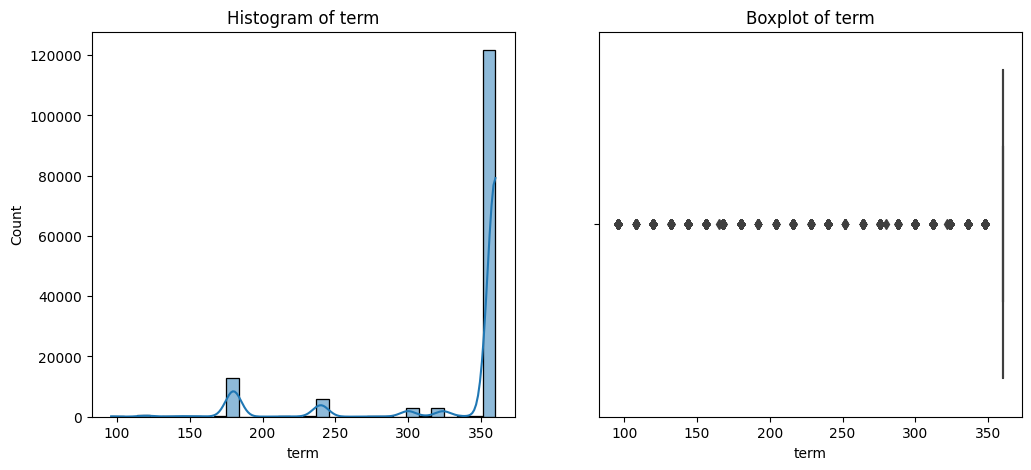

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


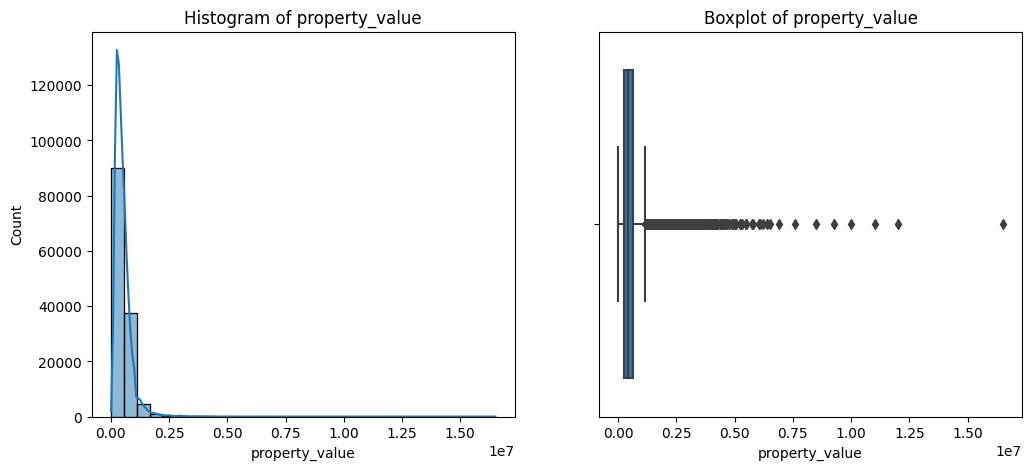

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


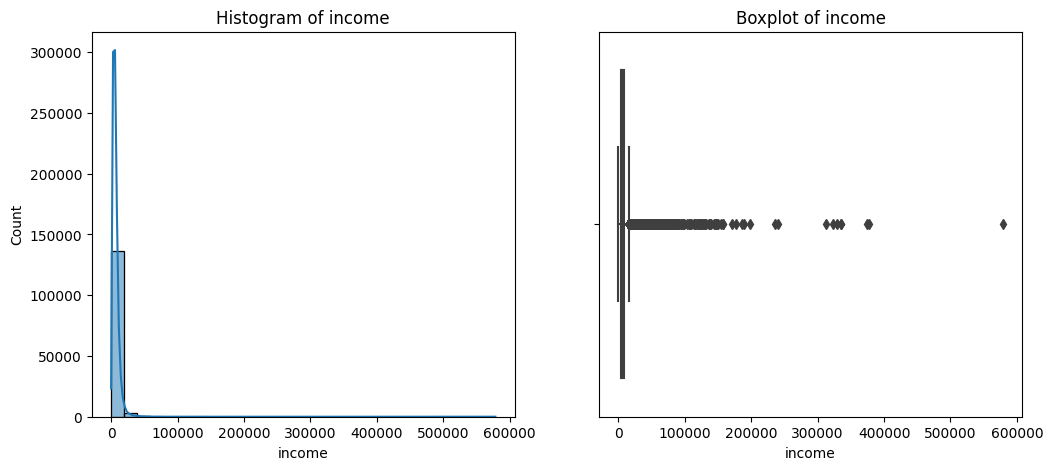

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


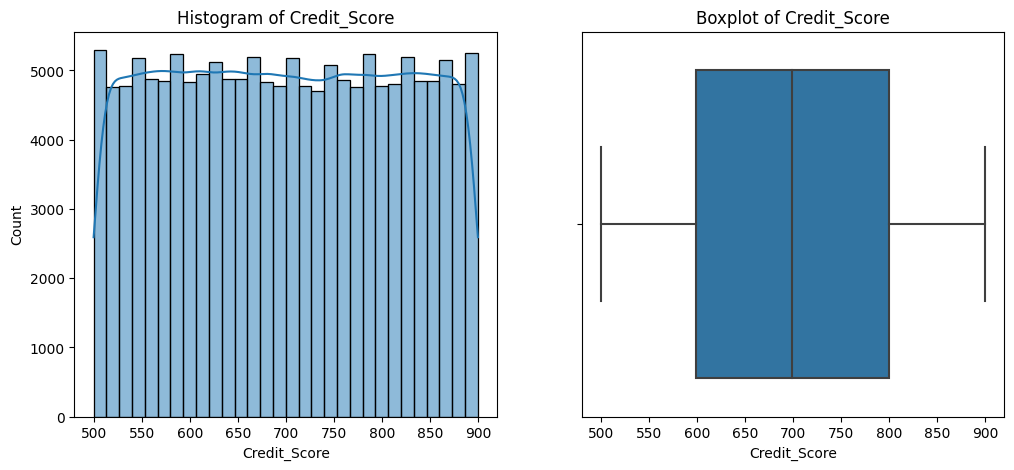

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


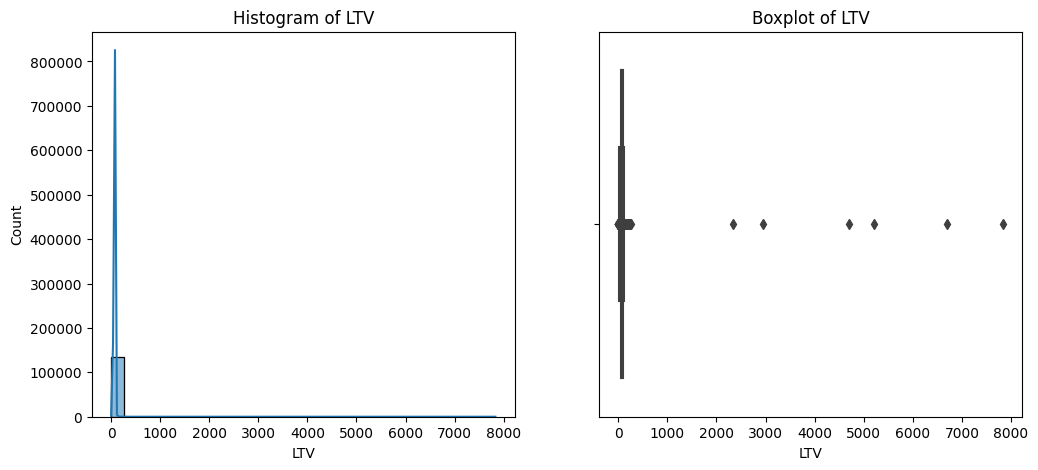

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


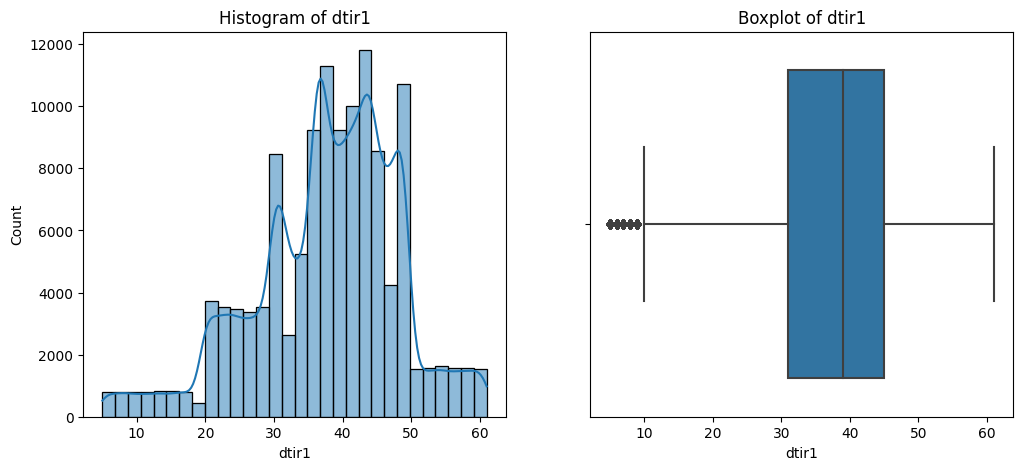

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


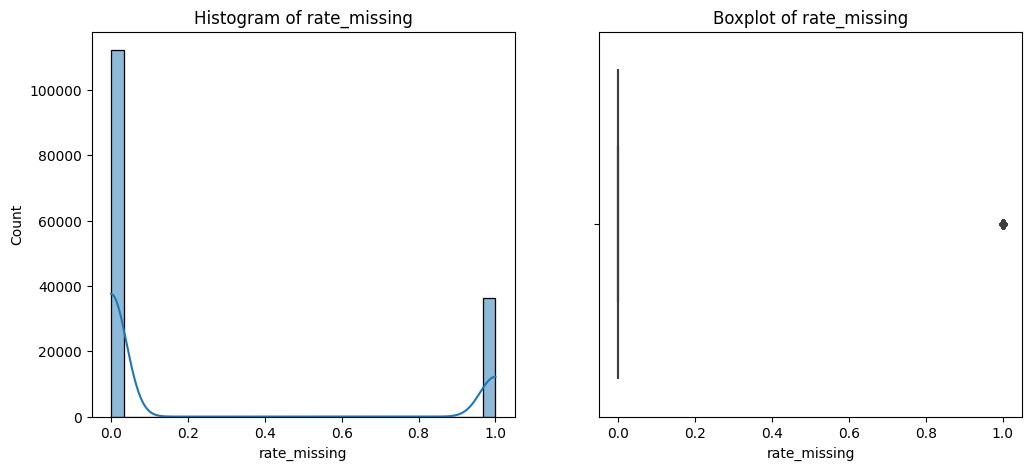

In [31]:
# 2. Distribution Plots
# -------------------------
def plot_distributions(df, num_cols, bins=30):
    for col in num_cols:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(df[col].dropna(), bins=bins, kde=True)
        plt.title(f"Histogram of {col}")
        
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col], orient="h")
        plt.title(f"Boxplot of {col}")
        plt.show()

plot_distributions(df, num_cols, bins=30)

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


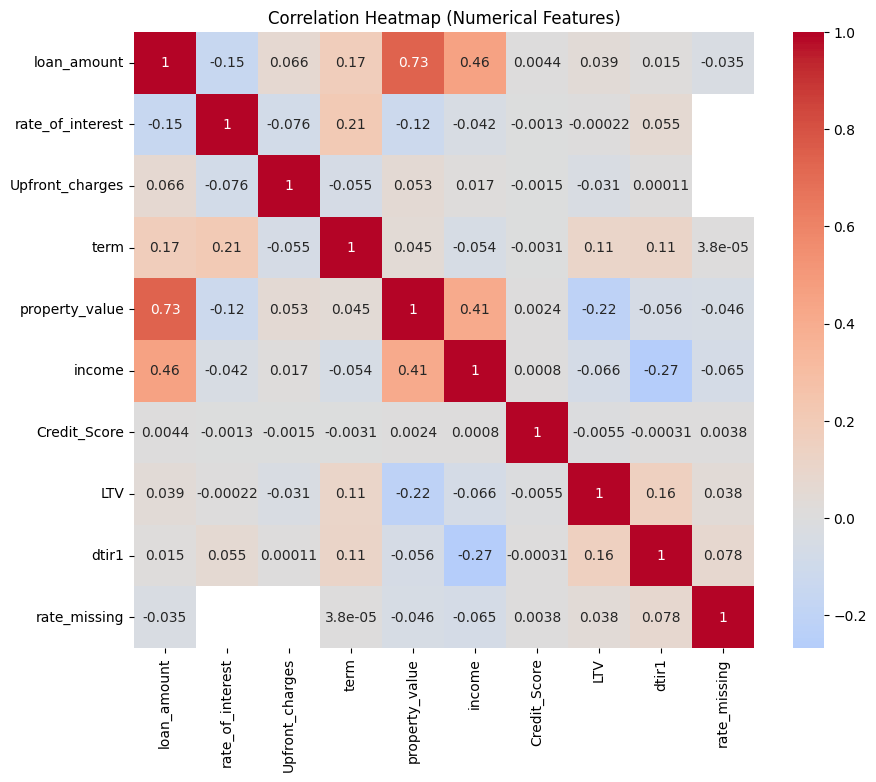

In [32]:

#  Correlation Heatmap

def correlation_heatmap(df, num_cols):
    corr = df[num_cols].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
    plt.title("Correlation Heatmap (Numerical Features)")
    plt.show()

correlation_heatmap(df, num_cols)

In [33]:
#loan_amount and property vlaue are highly correlated - 0.7

In [34]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [35]:
#Preprocessing Pipeline
def preprocess_numerical(df, num_cols, scaling='standard'):
    """
    Impute missing values and scale numeric features.
    scaling: 'standard' (StandardScaler) or 'minmax' (MinMaxScaler)
    """
    # Imputation (median robust against outliers)
    imputer = SimpleImputer(strategy='median')
    df[num_cols] = imputer.fit_transform(df[num_cols])

    # Handle skewness (log transform if skew > 1)
    for col in num_cols:
        if abs(skew(df[col])) > 1:
            df[col] = np.log1p(df[col])  # log(1+x) to avoid -inf for zeros

    # Scaling
    if scaling == 'standard':
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()
        
    df[num_cols] = scaler.fit_transform(df[num_cols])
    
    return df, imputer, scaler

In [36]:
class SkewnessHandler(BaseEstimator, TransformerMixin):
    """Custom transformer to handle skewed numerical features"""
    
    def __init__(self, threshold=1):
        self.threshold = threshold
        self.skewed_features = []
    
    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            for col in X.columns:
                if abs(skew(X[col])) > self.threshold:
                    self.skewed_features.append(col)
        else:
            # Handle numpy arrays
            for i in range(X.shape[1]):
                if abs(skew(X[:, i])) > self.threshold:
                    self.skewed_features.append(i)
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        if isinstance(X, pd.DataFrame):
            for col in self.skewed_features:
                X_transformed[col] = np.log1p(X_transformed[col])
        else:
            for i in self.skewed_features:
                X_transformed[:, i] = np.log1p(X_transformed[:, i])
        return X_transformed

def create_preprocessing_pipeline(X, y, cardinality_threshold=10):
    """
    Creates a comprehensive preprocessing pipeline that handles both
    numerical and categorical features dynamically.
    """
    
    # Identify column types
    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    
    print(f"Numerical columns ({len(num_cols)}): {num_cols}")
    print(f"Categorical columns ({len(cat_cols)}): {cat_cols}")
    
    # Separate categorical columns by cardinality
    low_card_cols = []
    high_card_cols = []
    
    for col in cat_cols:
        unique_count = X[col].nunique()
        if unique_count <= cardinality_threshold:
            low_card_cols.append(col)
        else:
            high_card_cols.append(col)
    
    print(f"Low cardinality categorical ({len(low_card_cols)}): {low_card_cols}")
    print(f"High cardinality categorical ({len(high_card_cols)}): {high_card_cols}")
    
    # Create transformers list
    transformers = []
    
    # Numerical features pipeline
    if num_cols:
        numerical_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('skewness', SkewnessHandler(threshold=1)),
            ('scaler', StandardScaler())
        ])
        transformers.append(('num', numerical_pipeline, num_cols))
    
    # Low cardinality categorical features
    if low_card_cols:
        low_card_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
        ])
        transformers.append(('low_card_cat', low_card_pipeline, low_card_cols))
    
    # High cardinality categorical features (target encoding)
    if high_card_cols:
        high_card_pipeline = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
            ('target_encoder', ce.TargetEncoder())
        ])
        transformers.append(('high_card_cat', high_card_pipeline, high_card_cols))
    
    # Create the column transformer
    preprocessor = ColumnTransformer(
        transformers=transformers,
        remainder='drop'
    )
    
    return preprocessor

In [37]:

# Create preprocessor
preprocessor = create_preprocessing_pipeline(X, y, cardinality_threshold=10)

# Create complete pipeline
from sklearn.linear_model import LogisticRegression

complete_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Train-test split for proper evaluation
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Fit and evaluate
complete_pipeline.fit(X_train, y_train)

# Predictions
y_train_pred = complete_pipeline.predict(X_train)
y_test_pred = complete_pipeline.predict(X_test)

# Evaluation
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print("=== TRAINING PERFORMANCE ===")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")

print("\n=== TEST PERFORMANCE ===")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

Numerical columns (10): ['loan_amount', 'rate_of_interest', 'Upfront_charges', 'term', 'property_value', 'income', 'Credit_Score', 'LTV', 'dtir1', 'rate_missing']
Categorical columns (18): ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'occupancy_type', 'total_units', 'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 'Region']
Low cardinality categorical (18): ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'occupancy_type', 'total_units', 'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 'Region']
High cardinality categorical (0): []
=== TRAINING PERFORMANCE ===
Accuracy: 1.0000

=== TEST PERFORMANCE ===
Accuracy: 1.0000

Classification Report:
 

In [38]:
# 1. REMOVE THE LEAKAGE COLUMN IMMEDIATELY
print("Original shape:", df.shape)
if 'rate_missing' in df.columns:
    df = df.drop(columns=['rate_missing'])
    print("Removed 'rate_missing' column - this was causing data leakage!")
print("New shape:", df.shape)

# 2. Start fresh with clean separation
X = df.drop("Status", axis=1) 
y = df["Status"]

# 3. SPLIT FIRST, then preprocess
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Create feature engineering that doesn't cause leakage
# Do this AFTER splitting, fit only on training data
def safe_feature_engineering(X_train, X_test):
    """Apply feature engineering safely to avoid leakage"""
    X_train_eng = X_train.copy()
    X_test_eng = X_test.copy()
    
    # Create Loan-to-Value Ratio
    # Calculate median values from training data only
    train_loan_median = X_train['loan_amount'].median()
    train_property_median = X_train['property_value'].median()
    
    # Apply to both sets using training statistics
    X_train_eng['Loan_to_Value_Ratio'] = X_train_eng['loan_amount'].fillna(train_loan_median) / X_train_eng['property_value'].fillna(train_property_median)
    X_test_eng['Loan_to_Value_Ratio'] = X_test_eng['loan_amount'].fillna(train_loan_median) / X_test_eng['property_value'].fillna(train_property_median)
    
    # Drop original columns
    X_train_eng = X_train_eng.drop(['loan_amount', 'property_value'], axis=1)
    X_test_eng = X_test_eng.drop(['loan_amount', 'property_value'], axis=1)
    
    return X_train_eng, X_test_eng

# Apply feature engineering
X_train_eng, X_test_eng = safe_feature_engineering(X_train, X_test)

# 5. Simple preprocessing pipeline (without target encoding for now)
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Get column types from training data
num_cols = X_train_eng.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X_train_eng.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numerical columns: {num_cols}")
print(f"Categorical columns: {cat_cols}")

# Simple preprocessing - no target encoding to avoid complexity
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
        ]), cat_cols)
    ],
    remainder='drop'
)

# 6. Create and fit pipeline ONLY on training data
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
])

# Fit only on training data
pipeline.fit(X_train_eng, y_train)

# 7. Evaluate
y_train_pred = pipeline.predict(X_train_eng)
y_test_pred = pipeline.predict(X_test_eng)

print("=== RESULTS ===")
print(f"Training Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")

# More detailed evaluation
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

# Check for remaining issues
print("\n=== DIAGNOSTIC CHECKS ===")
print(f"Training set class distribution: {y_train.value_counts(normalize=True).round(3).to_dict()}")
print(f"Test set class distribution: {y_test.value_counts(normalize=True).round(3).to_dict()}")
print(f"Predictions class distribution: {pd.Series(y_test_pred).value_counts(normalize=True).round(3).to_dict()}")

# If still getting perfect accuracy, there might be other issues
if accuracy_score(y_test, y_test_pred) > 0.99:
    print("\n⚠️  WARNING: Still getting suspiciously high accuracy!")
    print("Possible remaining issues:")
    print("1. Check if dataset has inherent leakage")
    print("2. Verify train-test split is working correctly") 
    print("3. Look for other columns that might contain future information")
    
    # Additional investigation
    print("\n--- Feature Importance Analysis ---")
    # Get feature names after preprocessing
    feature_names = (preprocessor.named_transformers_['num'].named_steps['imputer'].get_feature_names_out(num_cols).tolist() + 
                    preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_cols).tolist())
    
    # Get coefficients
    coef = pipeline.named_steps['classifier'].coef_[0]
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': np.abs(coef)
    }).sort_values('importance', ascending=False)
    
    print("Top 10 most important features:")
    print(importance_df.head(10))

Original shape: (148670, 29)
Removed 'rate_missing' column - this was causing data leakage!
New shape: (148670, 28)
Numerical columns: ['rate_of_interest', 'Upfront_charges', 'term', 'income', 'Credit_Score', 'LTV', 'dtir1', 'Loan_to_Value_Ratio']
Categorical columns: ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'Neg_ammortization', 'interest_only', 'lump_sum_payment', 'occupancy_type', 'total_units', 'credit_type', 'co-applicant_credit_type', 'age', 'submission_of_application', 'Region']
=== RESULTS ===
Training Accuracy: 0.8239
Test Accuracy: 0.8285

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89     22406
           1       0.64      0.68      0.66      7328

    accuracy                           0.83     29734
   macro avg       0.77      0.78      0.77     29734
weighted avg       0.83      0.83      0.83     2